# Garbage Classification with CNN
**Project Overview:** Building a Convolutional Neural Network to classify garbage into 6 categories using TensorFlow/Keras.

**Dataset:** https://www.kaggle.com/datasets/zlatan599/garbage-dataset-classification

## 1. Setup and Imports
Import necessary libraries for image processing, deep learning, and visualization.

In [26]:
# Core libraries
import os
import shutil
import random
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Image processing
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Sklearn for metrics
from sklearn.model_selection import train_test_split


# Settings
warnings.filterwarnings('ignore')

## 2. Hyperparameters and Configuration
Set global parameters for model training.

In [27]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

IMG_HEIGHT = 128
IMG_WIDTH = 128

# Training parameters
BATCH_SIZE = 16    
LEARNING_RATE = 0.0001
EPOCHS = 50   
DROPOUT_RATE = 0.3

### 2.1 GPU Configuration
Verify TensorFlow GPU availability for training.

In [28]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {'True' if tf.config.list_physical_devices('GPU') else 'False'}\n")

TensorFlow version: 2.18.0
GPU available: True



## 3. Data Exploration
### 3.1 Dataset Structure
Explore the dataset organization and class distribution.

In [29]:

base_path = '/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification'
images_path = f'{base_path}/images'

classes = os.listdir(images_path)

for class_name in os.listdir(images_path):
    count = len(os.listdir(f'{images_path}/{class_name}'))
    print(f"{class_name}: {count}")

metal: 2084
glass: 2500
paper: 2315
trash: 2500
cardboard: 2214
plastic: 2288


### 3.2 Sample Images Visualization
Display sample images from each class to understand the data variety.

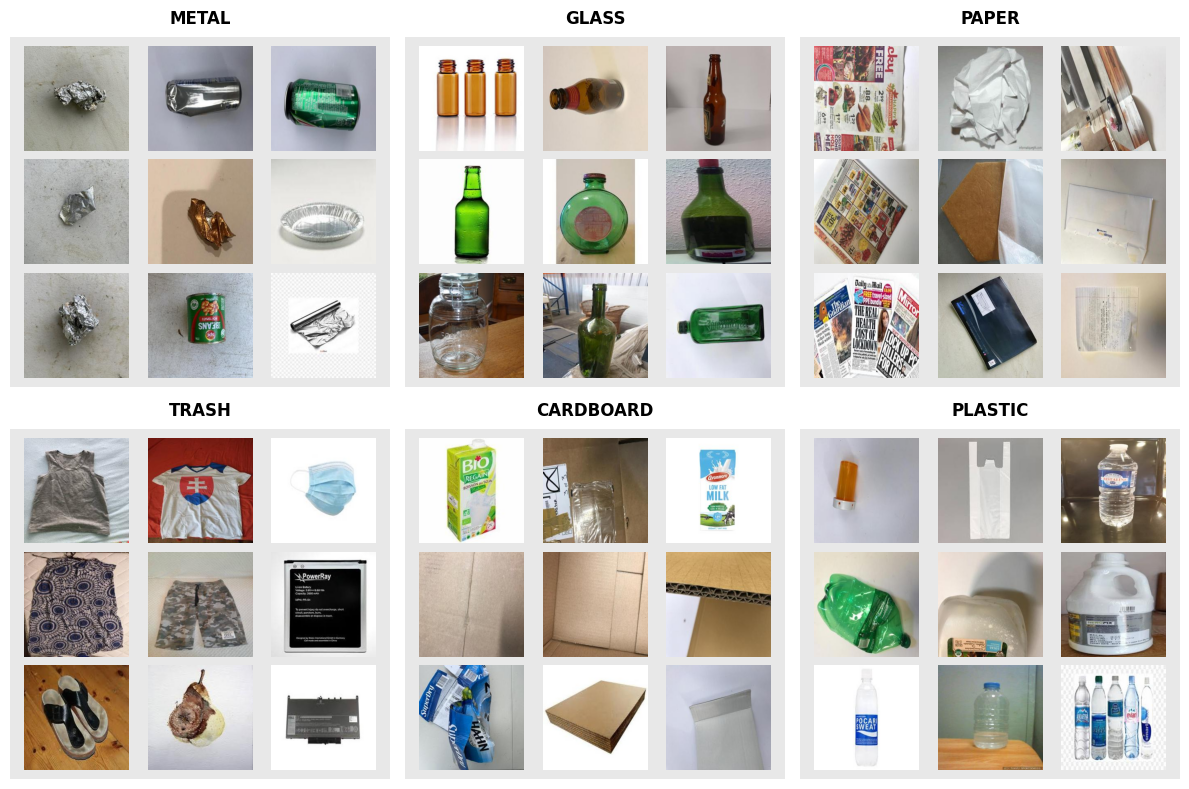

In [30]:
fig, main_axes = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)  # Add space between classes

for ax, class_name in zip(main_axes.flat, classes):
    # Get 9 random images from this class
    class_path = f'{images_path}/{class_name}'
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 9)
    
    # Style the class container
    ax.axis('off')
    ax.set_title(class_name.upper(), fontsize=12, weight='bold', pad=10)
    
    # Add subtle background for each class
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, fill=True, 
                               facecolor='lightgray', alpha=0.5))
    
    # Create 3x3 grid with small gaps
    for i in range(9):
        row, col = i // 3, i % 3
        img = Image.open(f'{class_path}/{sample_images[i]}')
        
        gap = 0.025  # Gap between images
        size = 0.3  # Image size
        left = col * (size + gap) + gap
        bottom = 1 - (row + 1) * (size + gap)
        
        mini_ax = ax.inset_axes([left, bottom, size, size])
        mini_ax.imshow(img)
        mini_ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing
### 4.1 Image Size Validation
Check image dimensions for consistency.

In [31]:
sizes = []
for class_name in classes:
    class_path = f'{images_path}/{class_name}'
    images = os.listdir(class_path)
    # Check every 20th image in each class
    for img_name in images[::20]:
        img = Image.open(f'{class_path}/{img_name}')
        sizes.append(img.size)

print(f"Image sizes: min={min(sizes)}, max={max(sizes)}")

Image sizes: min=(256, 256), max=(256, 256)


### 4.2 Train/Validation/Test Split
Split data into 70% training, 15% validation, and 15% test sets with stratification.

In [ ]:
# 1. Collect all files
all_files = []
all_labels = []
for class_name in classes:
    class_path = f'{images_path}/{class_name}'
    for file in os.listdir(class_path):
        all_files.append(f'{class_name}/{file}')
        all_labels.append(class_name)


# 2. Split 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


# 3. Create split folders
work_dir = '/kaggle/working/split_data'
for split in ['train', 'val', 'test']:
    for class_name in classes:
        os.makedirs(f'{work_dir}/{split}/{class_name}', exist_ok=True)


# 4. Copy images to respective folders
def copy_images(files, labels, split_name):
    for file, label in zip(files, labels):
        src = f'{images_path}/{file}'
        dst = f'{work_dir}/{split_name}/{label}/{file.split("/")[1]}'
        shutil.copy2(src, dst)
    print(f"{split_name}: {len(files)} images")

copy_images(X_train, y_train, 'train')
copy_images(X_val, y_val, 'val')
copy_images(X_test, y_test, 'test')

### 4.3 Data Generators Setup
Create data generators with augmentation for training and normalization for validation/test.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1, 
    shear_range=0.1,
    fill_mode='nearest'
)

In [ ]:
val_test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize to [0,1]
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    f'{work_dir}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    f'{work_dir}/val',  # ← f-string
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    f'{work_dir}/test',  # ← f-string
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

### 4.4 Data Augmentation Visualization
Demonstrate the effect of augmentation techniques on training images.

In [ ]:
fig, axes = plt.subplots(len(classes), 6, figsize=(9, 2*len(classes)))

for i, cls in enumerate(classes):
    # Get image
    img_file = np.random.choice([x for x, y in zip(X_train, y_train) if y == cls])
    img = image.load_img(f'{images_path}/{img_file}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    x = image.img_to_array(img).reshape((1, IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Plot row: original + augmented
    for j in range(6):
        axes[i,j].imshow(img if j==0 else next(train_datagen.flow(x, batch_size=1))[0])
        axes[i,j].axis('off')
        
        # Labels
        if i==0: axes[0,j].set_title('Original' if j==0 else f'A{j}', fontsize=7)
        if j==0: axes[i,0].text(-20, 64, cls.upper(), rotation=90, ha='center', va='center', fontsize=8, fontweight='bold')

plt.suptitle('Augmentation Examples', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Model Design
### 5.1 CNN Model Design
Build a deep CNN with 4 convolutional blocks and regularization techniques.

**Architecture:**
- 4 Conv blocks with increasing filters (32→64→128→256)
- BatchNormalization and Dropout for regularization

In [ ]:
def create_cnn_model_1(input_shape, num_classes):
    model = models.Sequential([
        # Block 1 - 32 filters
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2 - 64 filters
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3 - 128 filters
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(DROPOUT_RATE),
        
        # Block 4 - 256 filters
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(DROPOUT_RATE),
        
        # Fully connected
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [ ]:
model = create_cnn_model_1(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=len(classes)
)
model.summary()

### 5.2 Model Compilation
Configure optimizer, loss function, and metrics.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 5.3 Training Callbacks
Set up callbacks for model checkpointing, early stopping, and learning rate scheduling.

In [ ]:
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

## 6. Model Training
Train the model with augmented data and validation monitoring.

In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

### 6.1 Training History Visualization
Analyze training and validation metrics over epochs.

In [ ]:
def plot_training_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy
    ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training', linewidth=2)
    ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Loss
    ax2.plot(epochs, history.history['loss'], 'b-', label='Training', linewidth=2)
    ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation', linewidth=2)
    ax2.set_title('Model Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Training History', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

## 7. Model Evaluation
### 7.1 Test Set Performance
Evaluate the trained model on unseen test data.

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"  Test Accuracy: {test_accuracy:.1%}")
print(f"  Test Loss: {test_loss:.3f}")

In [ ]:
# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

### 7.2 Detailed Classification Metrics
Generate precision, recall, and F1-scores for each class.

In [ ]:
# Classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

### 7.3 Confusion Matrix Analysis
Visualize prediction patterns and misclassifications.

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 7.4 Class Performance
Calculate individual accuracy for each garbage category.

In [ ]:
# Class accuracy
for i, class_name in enumerate(class_names):
    if cm[i].sum() > 0:
        acc = cm[i, i] / cm[i].sum()
        print(f"  {class_name:15} {acc:.1%}")

## 8. Results Summary

In [ ]:
print(f"Total parameters: {model.count_params():,}")
print(f"Model achieved {test_accuracy:.1%} accuracy on the test set.")

### Potential Improvements:
- Fine-tune hyperparameters
- Try transfer learning with pre-trained models
- Collect more data for underperforming classes